## The Question: Do developing or developed nations produce more power per capita? ##
- Carly

In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns

global_power_path = "Resources/global_power_plant_database.csv"
global_gni_path = "Resources/Global_gni.csv"
global_population_path = "Resources/global_population_dataset.csv"

global_powerdf = pd.read_csv(global_power_path)
global_gnidf = pd.read_csv(global_gni_path)
global_population = pd.read_csv(global_population_path)

#global_gnidf.head()

C:\Users\carly\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
# Merge All Dataframes

global_population_cleandf = global_population[['Country Name', 'Country Code', '2020']]
#global_population_cleandf.head()

global_power_cleandf = global_powerdf[['country', 'country_long', 'name', 'capacity_mw', 'latitude', 'longitude', 'primary_fuel' ]]
global_power_cleandf.rename(columns={'country_long': 'Country Name',  'country': 'Country Code'}, inplace=True)
#global_power_cleandf.head()

global_gni_cleandf = global_gnidf[['Country Name', 'Country Code', '2020']]
global_gni_cleandf = global_gni_cleandf.dropna()
#global_gni_cleandf.head()

merged_power_plantdf = pd.merge(global_power_cleandf, global_gni_cleandf, how="left", on=["Country Code", "Country Code"])
#merged_power_plantdf.head()
merged_power_plantdf =  merged_power_plantdf[['Country Code', 'Country Name_x', 'name', 'capacity_mw', 'latitude', 'longitude', 'primary_fuel', '2020']]
#merged_power_plantdf.head()

merged_power_plantdf.rename(columns={'Country Name_x': 'Country Name',  '2020': 'GNI', 'capacity_mw': 'Power Plant Capacity(MWh)', 'latitude': 'Latitude',
'longitude': 'Longitude', 'name': 'Power Plant Name', 'primary_fuel': 'Primary Fuel'}, inplace=True)
#merged_power_plantdf.head()

merged_power_plantdf = pd.merge(merged_power_plantdf, global_population_cleandf, how="left", on=["Country Code", "Country Code"])
#merged_power_plantdf.head()

merged_power_plantdf = merged_power_plantdf[['Country Code', 'Country Name_x', 'Power Plant Name', 'Power Plant Capacity(MWh)', 'Latitude', 'Longitude', 'Primary Fuel', 'GNI', '2020']]
#merged_power_plantdf.head()

merged_power_plantdf.rename(columns={'Country Name_x': 'Country Name',  '2020': 'Population'}, inplace=True)

merged_power_plantdf.head()

C:\Users\carly\anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Country Code,Country Name,Power Plant Name,Power Plant Capacity(MWh),Latitude,Longitude,Primary Fuel,GNI,Population
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,33.0,32.322,65.1190,Hydro,500.0,38928341.0
1,AFG,Afghanistan,Kandahar DOG,10.0,31.670,65.7950,Solar,500.0,38928341.0
2,AFG,Afghanistan,Kandahar JOL,10.0,31.623,65.7920,Solar,500.0,38928341.0
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,66.0,34.556,69.4787,Hydro,500.0,38928341.0
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,100.0,34.641,69.7170,Hydro,500.0,38928341.0


In [47]:
# Add groups to indicate Country Status
#> 12615 - developing country
#< 12615 = developed country

merged_power_plantdf['GNI'].max()

bins = [0 , 12614, 83000]
group_Labels = ['Developing', 'Developed']

merged_power_plantdf["Country Status"] = pd.cut(merged_power_plantdf["GNI"], bins, labels=group_Labels)
#merged_power_plantdf.head()


In [48]:
# Create new dataframe to work in.
power_plant_capacity_df = merged_power_plantdf
# power_plant_capacity_df

In [49]:
# Add a new column to calculate the MW capacity for a year 
# (so it's a more manageable number to work with when divided by the population)
# There are 8760 hours in a year.
power_plant_capacity_df["Power Plant Capacity(MW per Year)"] = ((power_plant_capacity_df["Power Plant Capacity(MWh)"]) * (8760))
power_plant_capacity_df.head()

,Country Code,Country Name,Power Plant Name,Power Plant Capacity(MWh),Latitude,Longitude,Primary Fuel,GNI,Population,Country Status,Power Plant Capacity(MW per Year)
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,33.0,32.322,65.1190,Hydro,500.0,38928341.0,Developing,289080.0
1,AFG,Afghanistan,Kandahar DOG,10.0,31.670,65.7950,Solar,500.0,38928341.0,Developing,87600.0
2,AFG,Afghanistan,Kandahar JOL,10.0,31.623,65.7920,Solar,500.0,38928341.0,Developing,87600.0
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,66.0,34.556,69.4787,Hydro,500.0,38928341.0,Developing,578160.0
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,100.0,34.641,69.7170,Hydro,500.0,38928341.0,Developing,876000.0


In [50]:
# Group the data by the Country Code to get a total MW capacity for all of power plants in the country over the year.

# Reduce the table to just the necessary columns
power_plant_capacity_df_reduced = power_plant_capacity_df[["Country Code", "Power Plant Capacity(MW per Year)"]]

# Group by "Country Code"
power_plant_capacity_df_grouped = power_plant_capacity_df_reduced.groupby(["Country Code"], as_index=False)

# Get the sum of all "Power Plant Capacity(MW per Year)" values for each Country Code
power_plant_capacity_df_grouped = power_plant_capacity_df_grouped.sum()

power_plant_capacity_df_grouped

,Country Code,Power Plant Capacity(MW per Year)
0,AFG,2.632818e+06
1,AGO,9.383537e+06
2,ALB,1.339404e+07
3,ARE,2.656645e+08
4,ARG,2.883186e+08
...,...,...
162,VNM,3.622303e+08
163,YEM,9.154200e+06
164,ZAF,4.417029e+08
165,ZMB,2.355859e+07


In [51]:
# Add COUNTRIES COMBINED Power Plant Capacity (MW per Year) column

# Merge the group by sum of all "Power Plant Capacity(MW per Year)" values for each Country Code dataframe with the power_plant_capacity_df under as a new variable
power_plant_capacity_merged_df = pd.merge(power_plant_capacity_df, power_plant_capacity_df_grouped, how="left", on=["Country Code", "Country Code"])
#power_plant_capacity_merged_df

# clean up the power_plant_capacity_merged_df dataframe
power_plant_capacity_merged_df = power_plant_capacity_merged_df[['Country Name', 'Country Code', 'Country Status', 'GNI', 'Population', 'Power Plant Capacity(MW per Year)_y']]
power_plant_capacity_merged_df.rename(columns={'Power Plant Capacity(MW per Year)_y': 'Countries Combined Power Plant Capacity (MW per Year)'}, inplace=True)
power_plant_capacity_merged_df

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year)
0,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00
1,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00
2,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00
3,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00
4,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00
...,...,...,...,...,...,...
34931,Zambia,ZMB,Developing,1160.0,18383956.0,23558592.12
34932,Zambia,ZMB,Developing,1160.0,18383956.0,23558592.12
34933,Zambia,ZMB,Developing,1160.0,18383956.0,23558592.12
34934,Zimbabwe,ZWE,Developing,1140.0,14862927.0,14629200.00


In [52]:
# Add a new column to calculate the Countries Combined Power Plant Capacity (MW per Year) divided by the population

power_plant_capacity_merged_df["Countries Combined Power Plant Capacity (MW per Year) Per Capita"] = ((power_plant_capacity_merged_df["Countries Combined Power Plant Capacity (MW per Year)"]) / (power_plant_capacity_merged_df["Population"]))
power_plant_capacity_merged_df

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
0,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00,0.067632
1,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00,0.067632
2,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00,0.067632
3,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00,0.067632
4,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00,0.067632
...,...,...,...,...,...,...,...
34931,Zambia,ZMB,Developing,1160.0,18383956.0,23558592.12,1.281476
34932,Zambia,ZMB,Developing,1160.0,18383956.0,23558592.12,1.281476
34933,Zambia,ZMB,Developing,1160.0,18383956.0,23558592.12,1.281476
34934,Zimbabwe,ZWE,Developing,1140.0,14862927.0,14629200.00,0.984274


In [53]:
country_power_capacity_per_capita_df = power_plant_capacity_merged_df.drop_duplicates()
country_power_capacity_per_capita_df = country_power_capacity_per_capita_df.dropna()
country_power_capacity_per_capita_df = country_power_capacity_per_capita_df.round(3)
country_power_capacity_per_capita_df

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
0,Afghanistan,AFG,Developing,500.0,38928341.0,2.632818e+06,0.068
9,Albania,ALB,Developing,5210.0,2837743.0,1.339404e+07,4.720
17,Algeria,DZA,Developing,3570.0,43851043.0,1.390545e+08,3.171
76,Angola,AGO,Developing,2140.0,32866268.0,9.383537e+06,0.286
92,Argentina,ARG,Developing,9070.0,45376763.0,2.883186e+08,6.354
...,...,...,...,...,...,...,...
34543,Uruguay,URY,Developed,15790.0,3473727.0,3.687189e+07,10.615
34616,Uzbekistan,UZB,Developing,1740.0,34232050.0,1.107264e+08,3.235
34675,Vietnam,VNM,Developing,2650.0,97338583.0,3.622303e+08,3.721
34919,Zambia,ZMB,Developing,1160.0,18383956.0,2.355859e+07,1.281


Find the summary stats of Developing vs Developed Countries

In [54]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the:
# "Countries Combined Power Plant Capacity (MW per Year) Per Capita" for each "Country Status"

# use groupby function to calculate all required statistics
cpcpc_summary_stats_df = country_power_capacity_per_capita_df.groupby(["Country Status"]).agg({"Countries Combined Power Plant Capacity (MW per Year) Per Capita": ["mean", "median", "var", "std", "sem"]})

# re-align the headings so the columns headings can be re-named
cpcpc_summary_stats_df.columns = cpcpc_summary_stats_df.columns.droplevel(0)
cpcpc_summary_stats_df.rename(columns={"mean": "Mean MW of Power Per Person Per Year","median": "Median MW of Power Per Person Per Year", "var": "MW of Power Per Person Per Year Variance", "std": "MW of Power Per Person Per Year Standard Deviation", "sem": "MW of Power Per Person Per Year SEM",}, inplace=True)

cpcpc_summary_stats_df = cpcpc_summary_stats_df.round(2)

cpcpc_summary_stats_df

,Mean MW of Power Per Person Per Year,Median MW of Power Per Person Per Year,MW of Power Per Person Per Year Variance,MW of Power Per Person Per Year Standard Deviation,MW of Power Per Person Per Year SEM
Country Status,,,,,
Developing,3.16,1.73,13.23,3.64,0.35
Developed,17.38,13.30,126.62,11.25,1.68


Lets look at what outliers we may find with a box plot

In [55]:
# Generate a box plot of the "Countries Combined Power Plant Capacity (MW per Year) Per Capita" of each "Country Status"


Find max & min values for "Countries Combined Power Plant Capacity (MW per Year) Per Capita"

In [56]:
max_power_per_capita = country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'].max()
min_power_per_capita = country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'].min()

print (f"The highest power per capita value is {max_power_per_capita}")
print (f"The lowest power per capita value is {min_power_per_capita}")

The highest power per capita value is 59.399
The lowest power per capita value is 0.014


Find the top 10 Countries that have the capacity to produce the MOST power per capita

In [57]:
# Sort the country_power_capacity_per_capita_df by the values in the 'Countries Combined Power Plant Capacity (MW per Year) Per Capita' column to find the top 10 power producing Countries
top_producing_countries = country_power_capacity_per_capita_df.sort_values('Countries Combined Power Plant Capacity (MW per Year) Per Capita', ascending=False)

# Reset index
top_producing_countries = top_producing_countries.reset_index(drop=True)

# Cap the dataframe at 10 countries
top_producing_countries = top_producing_countries.head(10)

top_producing_countries

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
0,Iceland,ISL,Developed,62420.0,366425.0,2.176510e+07,59.399
1,Norway,NOR,Developed,78290.0,5379475.0,2.851468e+08,53.006
2,Bahrain,BHR,Developed,19900.0,1701583.0,6.645599e+07,39.055
3,Canada,CAN,Developed,43580.0,38005238.0,1.257749e+09,33.094
4,Qatar,QAT,Developed,55990.0,2881060.0,9.240048e+07,32.072
5,United States of America,USA,Developed,64530.0,329484123.0,1.055263e+10,32.028
6,United Arab Emirates,ARE,Developed,39410.0,9890400.0,2.656645e+08,26.861
7,Luxembourg,LUX,Developed,80860.0,632275.0,1.472556e+07,23.290
8,Australia,AUS,Developed,53690.0,25687041.0,5.768637e+08,22.457
9,Sweden,SWE,Developed,54050.0,10353442.0,2.314278e+08,22.353


(0.0, 60.0)

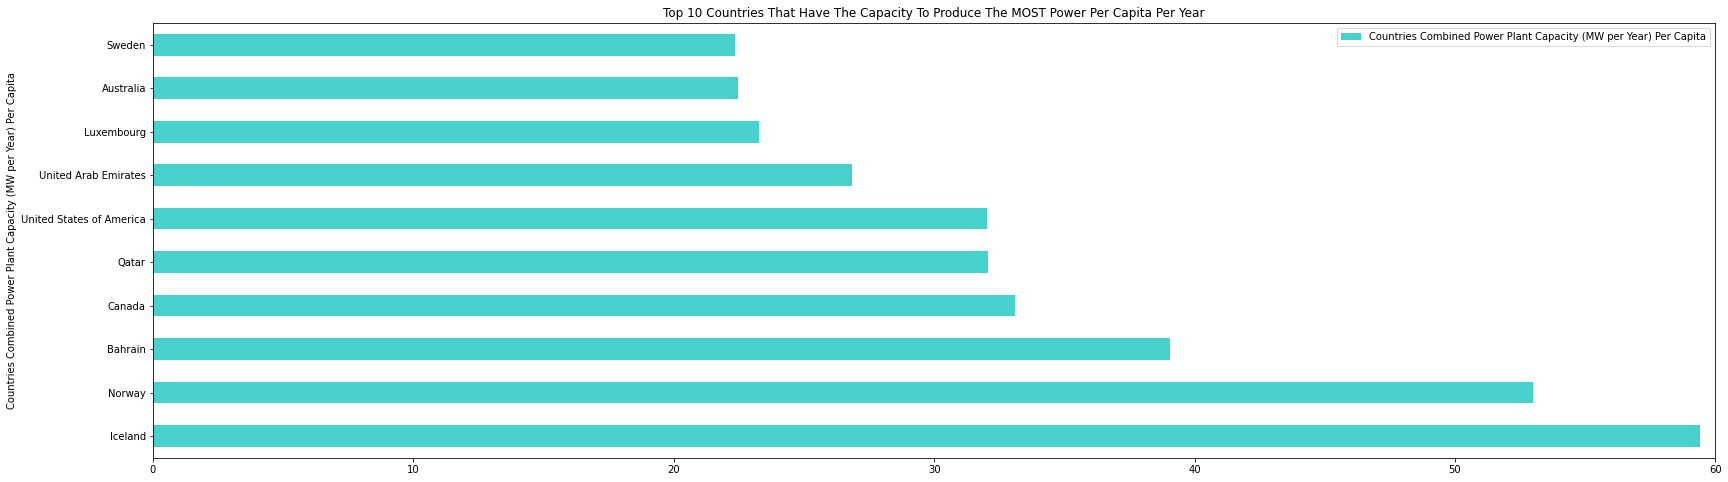

In [58]:
top_producing_countries.plot(x="Country Name", y="Countries Combined Power Plant Capacity (MW per Year) Per Capita", kind="barh", figsize=(28,8), color='mediumturquoise', title="Top 10 Countries That Have The Capacity To Produce The MOST Power Per Capita Per Year")
plt.ylabel("Countries Combined Power Plant Capacity (MW per Year) Per Capita")
plt.xlim(0, 60)

Find the top 10 Countries that have the capacity to produce the LEAST power per capita

In [59]:
# Sort the country_power_capacity_per_capita_df by the values in the 'Countries Combined Power Plant Capacity (MW per Year) Per Capita' column to find the top 10 power producing Countries
bottom_producing_countries = country_power_capacity_per_capita_df.sort_values('Countries Combined Power Plant Capacity (MW per Year) Per Capita', ascending=True)

# Reset index
bottom_producing_countries = bottom_producing_countries.reset_index(drop=True)

# Cap the dataframe at 10 countries
bottom_producing_countries = bottom_producing_countries.head(10)

bottom_producing_countries

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
0,Palestine,PSE,Developing,3710.0,4803269.0,66576.00,0.014
1,Burundi,BDI,Developing,230.0,11890781.0,500809.20,0.042
2,Benin,BEN,Developing,1280.0,12123198.0,529980.00,0.044
3,Central African Republic,CAF,Developing,500.0,4829764.0,294896.64,0.061
4,Niger,NER,Developing,550.0,24206636.0,1464672.00,0.061
5,Afghanistan,AFG,Developing,500.0,38928341.0,2632818.00,0.068
6,Suriname,SUR,Developing,4620.0,586634.0,43800.00,0.075
7,Guinea-Bissau,GNB,Developing,760.0,1967998.0,159756.12,0.081
8,Burkina Faso,BFA,Developing,770.0,20903278.0,2008720.56,0.096
9,Madagascar,MDG,Developing,470.0,27691019.0,3152986.80,0.114


(0.0, 60.0)

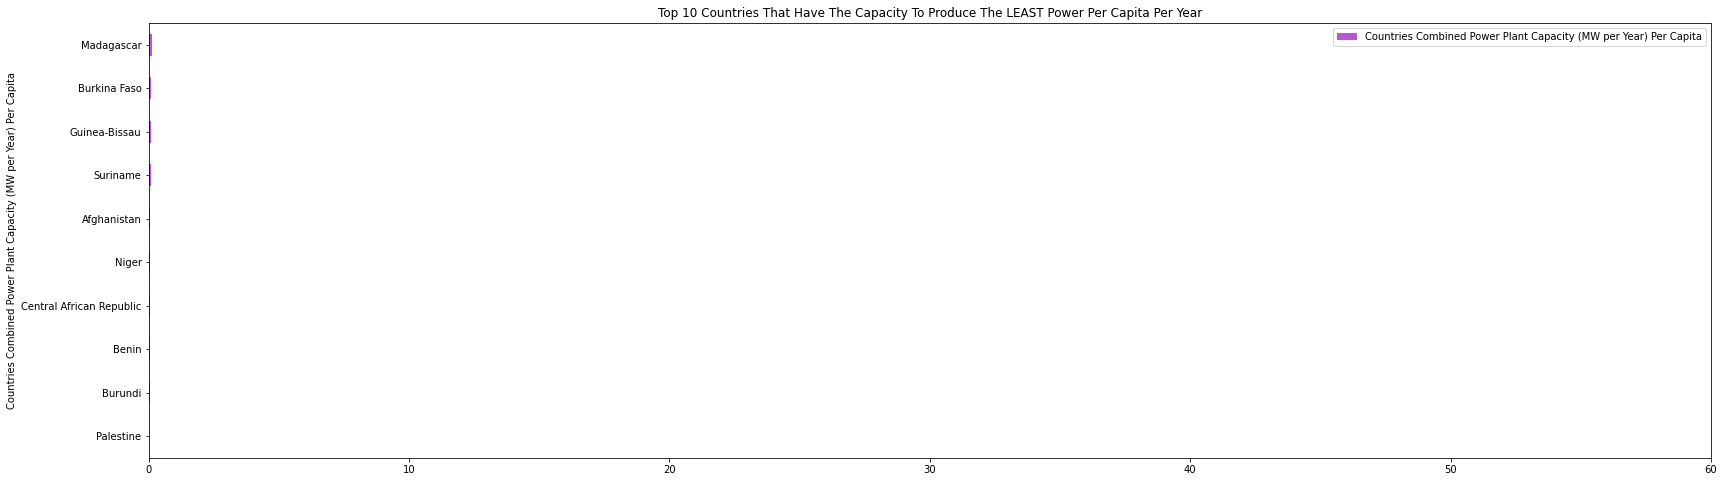

In [60]:
bottom_producing_countries.plot(x="Country Name", y="Countries Combined Power Plant Capacity (MW per Year) Per Capita", kind="barh", figsize=(28,8), color='mediumorchid', title="Top 10 Countries That Have The Capacity To Produce The LEAST Power Per Capita Per Year")
plt.ylabel("Countries Combined Power Plant Capacity (MW per Year) Per Capita")
plt.xlim(0, 60)

Text(0, 0.5, 'Countries Combined Power Plant Capacity (MW per Year) Per Capita')

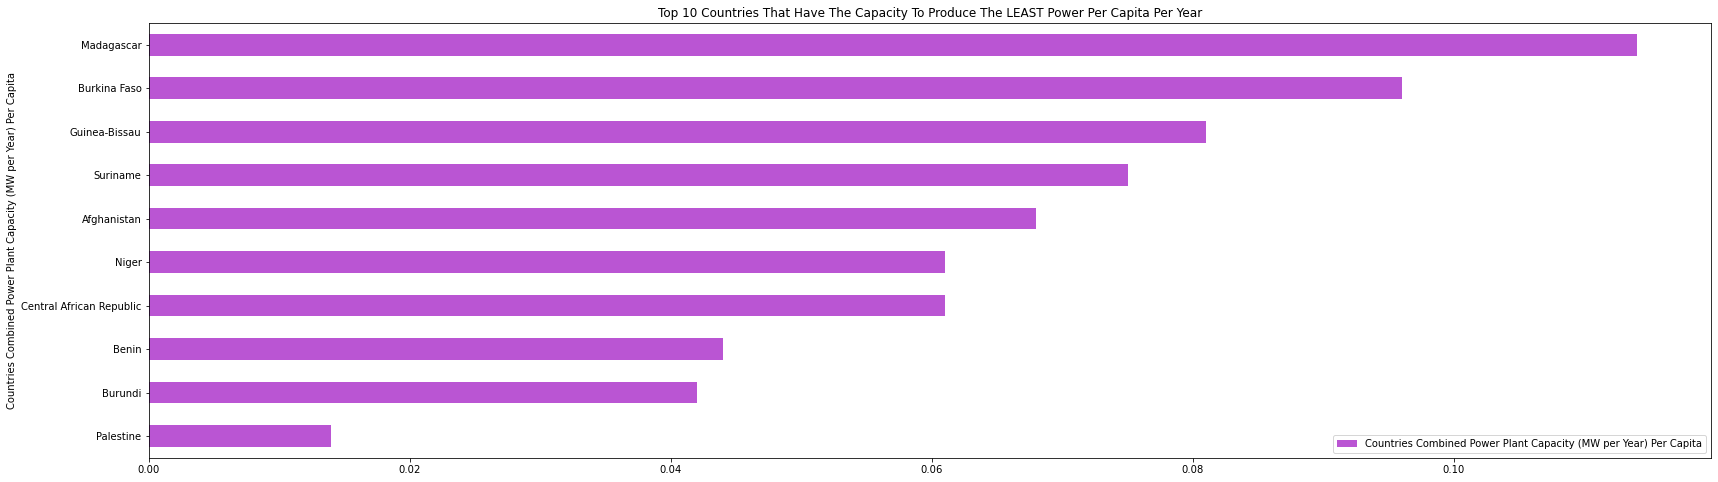

In [61]:
bottom_producing_countries.plot(x="Country Name", y="Countries Combined Power Plant Capacity (MW per Year) Per Capita", kind="barh", figsize=(28,8), color='mediumorchid', title="Top 10 Countries That Have The Capacity To Produce The LEAST Power Per Capita Per Year")
plt.ylabel("Countries Combined Power Plant Capacity (MW per Year) Per Capita")


In [127]:
country_power_capacity_per_capita_df = country_power_capacity_per_capita_df.sort_values('Countries Combined Power Plant Capacity (MW per Year) Per Capita', ascending=False)

TypeError: tuple indices must be integers or slices, not str

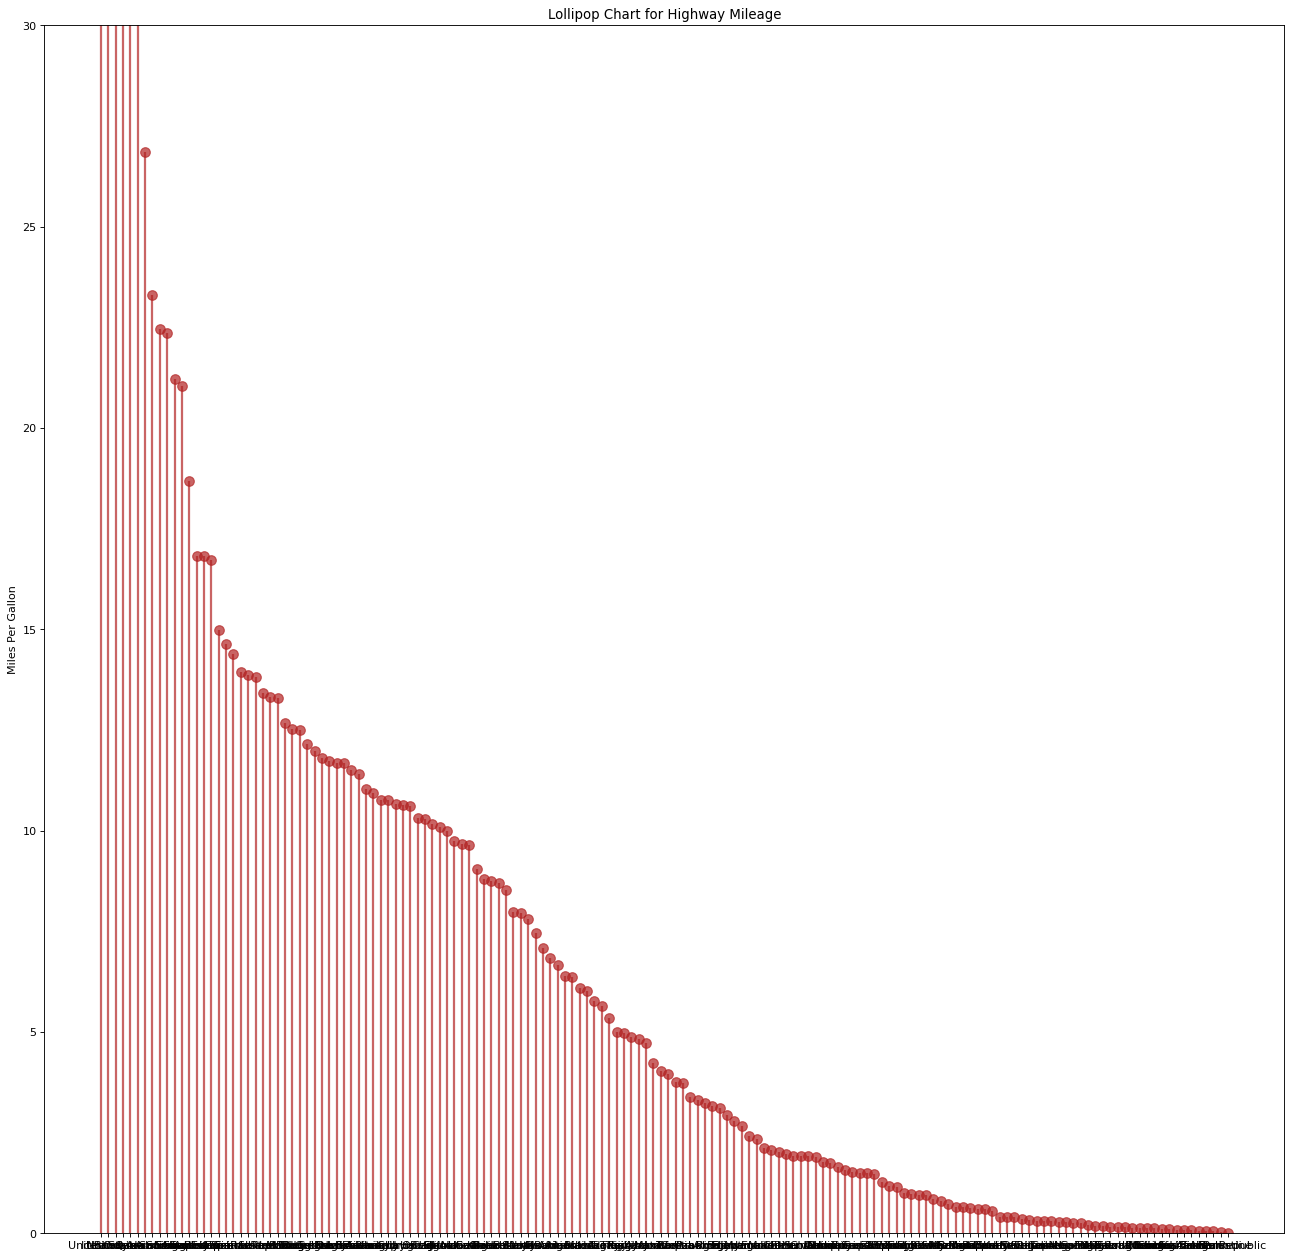

In [135]:
# Draw plot
fig, ax = plt.subplots(figsize=(20,20), dpi= 80)
ax.vlines(x=country_power_capacity_per_capita_df["Country Name"], ymin=0, ymax=country_power_capacity_per_capita_df["Countries Combined Power Plant Capacity (MW per Year) Per Capita"], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=country_power_capacity_per_capita_df["Country Name"], y=country_power_capacity_per_capita_df["Countries Combined Power Plant Capacity (MW per Year) Per Capita"], s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Lollipop Chart for Highway Mileage')
ax.set_ylabel('Miles Per Gallon')
ax.set_xticks(country_power_capacity_per_capita_df["Country Name"])
ax.set_ylim(0, 30)

# Annotate
for row in country_power_capacity_per_capita_df.itertuples():
    ax.text(row["Country Name"], row["Countries Combined Power Plant Capacity (MW per Year) Per Capita"]+.5, s=round(row["Countries Combined Power Plant Capacity (MW per Year) Per Capita"], 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

What percentage of countries are developed vs developing?

Text(0.5, 1.0, 'Percentage of Developed Countries vs Developing Countries in the United Nations dataset')

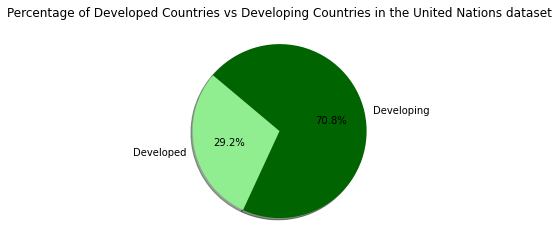

In [63]:
# Generate a pie plot showing the distribution of developed versus developing countries in the dataset

number_of_developed_countries = len(country_power_capacity_per_capita_df.loc[country_power_capacity_per_capita_df["Country Status"] == "Developed"])
number_of_developed_countries

number_of_developing_countries = len(country_power_capacity_per_capita_df.loc[country_power_capacity_per_capita_df["Country Status"] == "Developing"])
number_of_developing_countries

# Labels for the sections of our pie chart
labels = ["Developed", "Developing"]

# The values of each section of the pie chart
sizes = [number_of_developed_countries, number_of_developing_countries]

# The colors of each section of the pie chart
colors = ["lightgreen", "darkgreen"]

# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Percentage of Developed Countries vs Developing Countries in the United Nations dataset")

Furthermore, what percentage of the population lives in a developed Country, vs lives in a developing Country?

In [64]:
# Group the data by the Country Code to get a total number of people living in developed countries vs developing countries

# Reduce the table to just the necessary columns
population_distribution_df = country_power_capacity_per_capita_df[["Country Status", "Population"]]

# Group by "Country Status"
population_distribution_df = population_distribution_df.groupby(["Country Status"], as_index=False)

# Get the total number of people living in developed countries vs developing countries
population_distribution_df = population_distribution_df.sum()

population_distribution_df

,Country Status,Population
0,Developing,6.362254e+09
1,Developed,1.172255e+09


In [65]:
# # Generate a pie plot showing the distribution of developed versus developing countries in the dataset

# # what is the value of the population column when the country status == Developed
# number_of_people_living_in_developed_countries = (sum(population_distribution_df.loc[population_distribution_df["Country Status"] == "Developed"]))
# number_of_people_living_in_developed_countries

# number_of_people_living_in_developing_countries = (sum(population_distribution_df.loc[population_distribution_df["Country Status"] == "Developing"]))
# number_of_people_living_in_developing_countries

# # Labels for the sections of our pie chart
# labels = ["Developed", "Developing"]

# # The values of each section of the pie chart
# sizes = [number_of_people_living_in_developed_countries, number_of_people_living_in_developing_countries]

# # The colors of each section of the pie chart
# colors = ["lightblue", "darkblue"]

# # Creates the pie chart based upon the values above
# # Automatically finds the percentages of each part of the pie chart
# plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", shadow=True, startangle=140)
# plt.title("Percentage of People Living in Developed Countries vs Developing Countries in the United Nations dataset")

Is there a relationship between GNI and power capacity per capita per year?

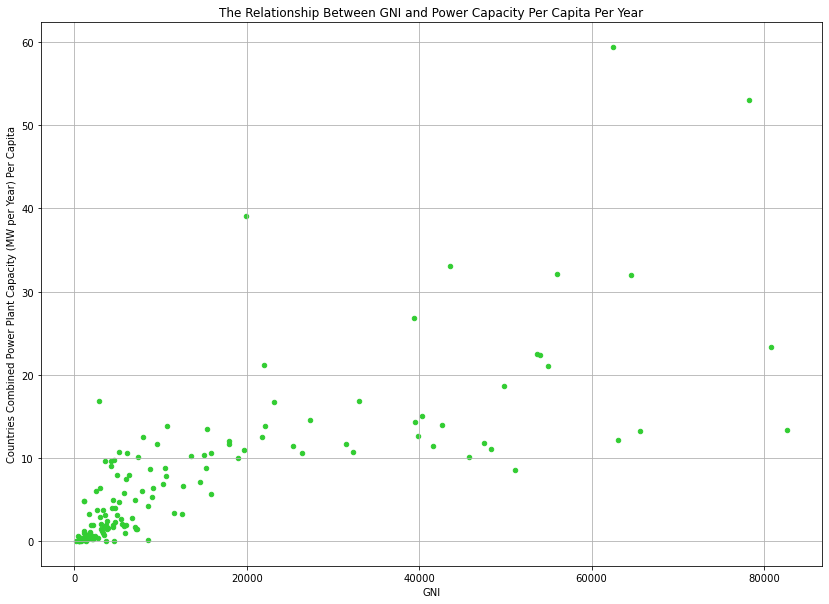

In [66]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
country_power_capacity_per_capita_df.plot(kind="scatter", x="GNI", y="Countries Combined Power Plant Capacity (MW per Year) Per Capita", 
grid=True, figsize=(14,10), color='limegreen', title="The Relationship Between GNI and Power Capacity Per Capita Per Year")

In [67]:
# # Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
# country_power_capacity_per_capita_df.plot
# (kind="scatter", x="GNI", y="Countries Combined Power Plant Capacity (MW per Year) Per Capita", 
# grid=True, figsize=(14,10), color='limegreen', title="The Relationship Between GNI and Power Capacity Per Capita Per Year")

In [68]:
correlation=round(st.pearsonr(country_power_capacity_per_capita_df['GNI'],country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'])[0],2)
print(f"The correlation coefficient is {correlation}")

model=st.linregress(country_power_capacity_per_capita_df['GNI'],country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'])
model

The correlation coefficient is 0.76


LinregressResult(slope=0.0003782103947466141, intercept=2.0665832124499026, rvalue=0.7646476331300114, pvalue=8.346048309885305e-31, stderr=2.585464639173381e-05)

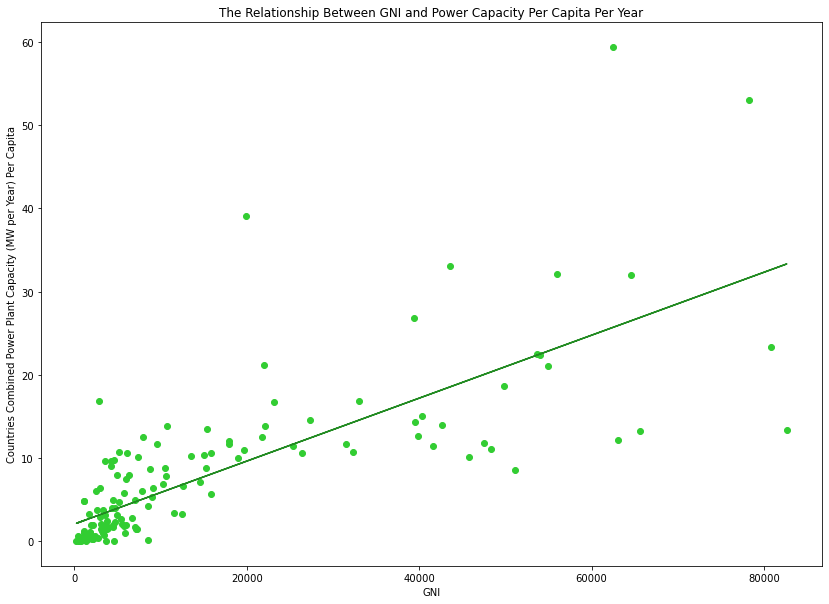

In [69]:
slope = 0.0003782103947466141
intercept = 2.0665832124499026

y_axis = country_power_capacity_per_capita_df['GNI']*slope+intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.subplots(figsize=(14,10))
plt.scatter(country_power_capacity_per_capita_df['GNI'],country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'], color='limegreen')
plt.plot(country_power_capacity_per_capita_df['GNI'],y_axis,color="forestgreen")
plt.xlabel('GNI')
plt.ylabel('Countries Combined Power Plant Capacity (MW per Year) Per Capita');
plt.title("The Relationship Between GNI and Power Capacity Per Capita Per Year")
plt.show()

## OKAY SO i want to crfeate bins based on the interquartile range of the mean of all the data, and see what percentage of developed countries occupy the top quartile

In [70]:
#country_power_capacity_per_capita_df

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
0,Afghanistan,AFG,Developing,500.0,38928341.0,2.632818e+06,0.068
9,Albania,ALB,Developing,5210.0,2837743.0,1.339404e+07,4.720
17,Algeria,DZA,Developing,3570.0,43851043.0,1.390545e+08,3.171
76,Angola,AGO,Developing,2140.0,32866268.0,9.383537e+06,0.286
92,Argentina,ARG,Developing,9070.0,45376763.0,2.883186e+08,6.354
...,...,...,...,...,...,...,...
34543,Uruguay,URY,Developed,15790.0,3473727.0,3.687189e+07,10.615
34616,Uzbekistan,UZB,Developing,1740.0,34232050.0,1.107264e+08,3.235
34675,Vietnam,VNM,Developing,2650.0,97338583.0,3.622303e+08,3.721
34919,Zambia,ZMB,Developing,1160.0,18383956.0,2.355859e+07,1.281


In [73]:
developed_pcpc_df = country_power_capacity_per_capita_df.loc[country_power_capacity_per_capita_df["Country Status"] == "Developed"]
#developed_pcpc_df

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
336,Australia,AUS,Developed,53690.0,25687041.0,5.768637e+08,22.457
822,Austria,AUT,Developed,48350.0,8917205.0,9.834940e+07,11.029
939,Bahrain,BHR,Developed,19900.0,1701583.0,6.645599e+07,39.055
1028,Belgium,BEL,Developed,45750.0,11555997.0,1.174260e+08,10.161
3512,Brunei Darussalam,BRN,Developed,31510.0,437483.0,5.133360e+06,11.734
3594,Canada,CAN,Developed,43580.0,38005238.0,1.257749e+09,33.094
4759,Chile,CHL,Developed,13470.0,19116209.0,1.968867e+08,10.299
9377,Croatia,HRV,Developed,14530.0,4047200.0,2.868462e+07,7.088
9415,Cyprus,CYP,Developed,26440.0,1207361.0,1.285968e+07,10.651
9418,Czech Republic,CZE,Developed,22070.0,10698896.0,1.477961e+08,13.814


In [76]:
# DEVELOPED

# Determine if there are any potential outliers in the average occupancy in California
quartiles = developed_pcpc_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {lowerq}")
print(f"The upper quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {upperq}")
print(f"The interquartile range of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {iqr}")
print(f"The the median of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_occupancy = developed_pcpc_df.loc[(developed_pcpc_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'] < lower_bound) | (country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'] > upper_bound)]
outlier_occupancy

The lower quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 10.942
The upper quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 21.046
The interquartile range of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 10.104
The the median of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 13.298 
Values below -4.213999999999999 could be outliers.
Values above 36.202 could be outliers.


,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
939,Bahrain,BHR,Developed,19900.0,1701583.0,66455988.0,39.055
14032,Iceland,ISL,Developed,62420.0,366425.0,21765096.0,59.399
17866,Norway,NOR,Developed,78290.0,5379475.0,285146760.0,53.006


In [74]:
developing_pcpc_df = country_power_capacity_per_capita_df.loc[country_power_capacity_per_capita_df["Country Status"] == "Developing"]
developing_pcpc_df

,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
0,Afghanistan,AFG,Developing,500.0,38928341.0,2.632818e+06,0.068
9,Albania,ALB,Developing,5210.0,2837743.0,1.339404e+07,4.720
17,Algeria,DZA,Developing,3570.0,43851043.0,1.390545e+08,3.171
76,Angola,AGO,Developing,2140.0,32866268.0,9.383537e+06,0.286
92,Argentina,ARG,Developing,9070.0,45376763.0,2.883186e+08,6.354
...,...,...,...,...,...,...,...
21865,Ukraine,UKR,Developing,3570.0,44134693.0,4.254714e+08,9.640
34616,Uzbekistan,UZB,Developing,1740.0,34232050.0,1.107264e+08,3.235
34675,Vietnam,VNM,Developing,2650.0,97338583.0,3.622303e+08,3.721
34919,Zambia,ZMB,Developing,1160.0,18383956.0,2.355859e+07,1.281


In [75]:
# DEVELOPING

# Determine if there are any potential outliers in the average occupancy in California
quartiles = developing_pcpc_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {lowerq}")
print(f"The upper quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {upperq}")
print(f"The interquartile range of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {iqr}")
print(f"The the median of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_occupancy = developing_pcpc_df.loc[(developing_pcpc_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'] < lower_bound) | (country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'] > upper_bound)]
outlier_occupancy


The lower quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 0.34
The upper quartile of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 4.865
The interquartile range of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 4.525
The the median of Countries Combined Power Plant Capacity (MW per Year) Per Capita is: 1.732 
Values below -6.447500000000001 could be outliers.
Values above 11.6525 could be outliers.


,Country Name,Country Code,Country Status,GNI,Population,Countries Combined Power Plant Capacity (MW per Year),Countries Combined Power Plant Capacity (MW per Year) Per Capita
1099,Bhutan,BTN,Developing,2840.0,771612.0,1.298407e+07,16.827
3516,Bulgaria,BGR,Developing,9630.0,6934015.0,8.104927e+07,11.689
17572,Montenegro,MNE,Developing,7900.0,621306.0,7.756980e+06,12.485
19175,Russia,RUS,Developing,10690.0,144104080.0,1.999208e+09,13.873


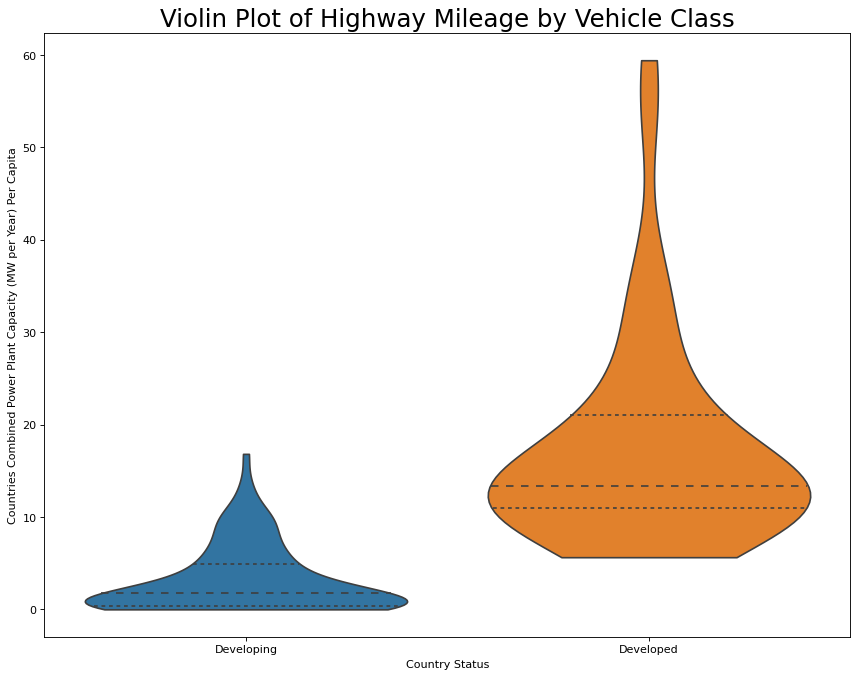

In [88]:

# Draw Plot
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(y='Countries Combined Power Plant Capacity (MW per Year) Per Capita', x='Country Status', data=country_power_capacity_per_capita_df, scale='width', inner='quartile', cut=0)

# Decoration
plt.title('Violin Plot of Highway Mileage by Vehicle Class', fontsize=22)
plt.show()

In [96]:
developing_list = developing_pcpc_df["Countries Combined Power Plant Capacity (MW per Year) Per Capita"]
#developing_list

0        0.068
9        4.720
17       3.171
76       0.286
92       6.354
         ...  
21865    9.640
34616    3.235
34675    3.721
34919    1.281
34934    0.984
Name: Countries Combined Power Plant Capacity (MW per Year) Per Capita, Length: 109, dtype: float64

In [97]:
developed_list = developed_pcpc_df["Countries Combined Power Plant Capacity (MW per Year) Per Capita"]
#developed_list

336      22.457
822      11.029
939      39.055
1028     10.161
3512     11.734
3594     33.094
4759     10.299
9377      7.088
9415     10.651
9418     13.814
9895     12.146
10063    16.729
10105    18.685
10290    14.379
12478    11.791
13793    11.983
14014     5.652
14032    59.399
15954    13.298
16013    13.939
16072    10.752
16478    14.993
17128    11.687
17155    10.942
17161    23.290
17685     8.535
17756    11.500
17866    53.006
18172    10.311
18437     8.749
18626    12.534
19095    32.072
19732    21.222
19847    21.046
19861     9.999
19891    11.412
20003    16.828
20135    14.621
21038    22.353
21206    13.305
21651    13.424
21929    26.861
21959    12.662
24710    32.028
34543    10.615
Name: Countries Combined Power Plant Capacity (MW per Year) Per Capita, dtype: float64

In [98]:
combined_country_status_list = [developed_list, developing_list]
#combined_country_status_list

[336      22.457
 822      11.029
 939      39.055
 1028     10.161
 3512     11.734
 3594     33.094
 4759     10.299
 9377      7.088
 9415     10.651
 9418     13.814
 9895     12.146
 10063    16.729
 10105    18.685
 10290    14.379
 12478    11.791
 13793    11.983
 14014     5.652
 14032    59.399
 15954    13.298
 16013    13.939
 16072    10.752
 16478    14.993
 17128    11.687
 17155    10.942
 17161    23.290
 17685     8.535
 17756    11.500
 17866    53.006
 18172    10.311
 18437     8.749
 18626    12.534
 19095    32.072
 19732    21.222
 19847    21.046
 19861     9.999
 19891    11.412
 20003    16.828
 20135    14.621
 21038    22.353
 21206    13.305
 21651    13.424
 21929    26.861
 21959    12.662
 24710    32.028
 34543    10.615
 Name: Countries Combined Power Plant Capacity (MW per Year) Per Capita, dtype: float64,
 0        0.068
 9        4.720
 17       3.171
 76       0.286
 92       6.354
          ...  
 21865    9.640
 34616    3.235
 34675    3.721
 3

Text(0, 0.5, 'Country Status Power Capacity (MW) Per Capita')

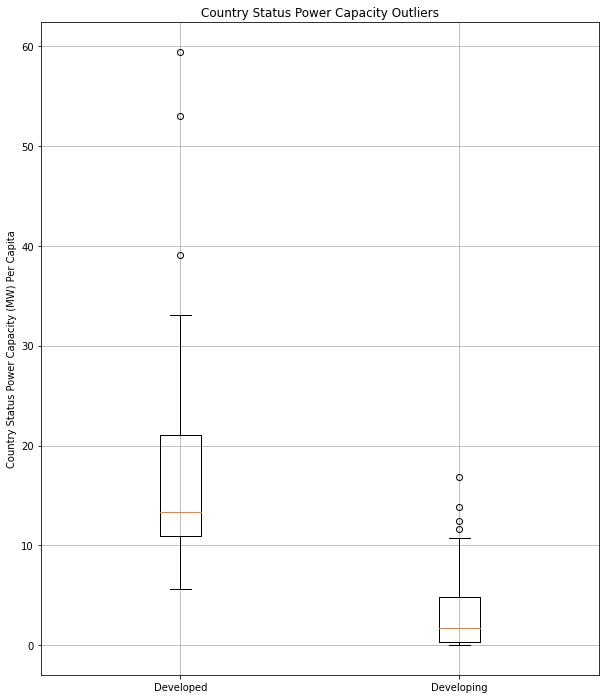

In [137]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

plt.subplots(figsize=(10,12))
plt.boxplot(combined_country_status_list)
plt.grid()
plt.xticks([1, 2], ["Developed", "Developing"])
plt.title("Country Status Power Capacity Outliers")
plt.ylabel("Country Status Power Capacity (MW) Per Capita")
# boxprops = dict(linestyle='--', linewidth=3, color='darkgoldenrod')
# flierprops = dict(marker='o', markerfacecolor='green', markersize=12, linestyle='none')
# medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
# meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
# meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

# plt.scatter(country_power_capacity_per_capita_df['GNI'],country_power_capacity_per_capita_df['Countries Combined Power Plant Capacity (MW per Year) Per Capita'], color='limegreen')
# plt.plot(country_power_capacity_per_capita_df['GNI'],y_axis,color="forestgreen")


## Notes for the data story ##

What can you do with a megawatt-hour of electricity?
(https://www.freeingenergy.com/what-is-a-megawatt-hour-of-electricity-and-what-can-you-do-with-it/)

    Power the average American home for 1.2 months.
    Drive an electric vehicle 3,600 miles.
    Power two 60-watt lightbulbs non-stop for a year.
    Smelt 137 pounds of aluminum.
    Toast 89,000 slices of bread.
    Run an average home pool pump for 5 months.


What can you run on 1 kWh?
(https://www.novec.com/Save/1-kWh.cfm)

    Blend 200 smoothies.
    Microwave 21 frozen burritos.
    Trim 3 miles of weeds.
    Make 60 quarts of ice cream.
    Keep cool with 20 hours of a ceiling fan.
    Binge watch 3 hours of television on a plasma TV or 6 hours on an LCD TV.
    Blow-dry 20 heads of hair.
    Toast 160 slices of bread.


QUICK MATHS: One megawatt (MW) = 1,000 kilowatts 